In [1]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
import torch
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [58]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import torch.nn as nn
import torch.optim as optim

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

# Downsample the training data
train_indices = torch.arange(0, 1000)
train_dataset = Subset(train_dataset, train_indices)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a small CNN model
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 8 * 7 * 7)
        x = self.fc1(x)
        return x

# Initialize the model, loss function, and optimizer
model = SmallCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Check the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Epoch 1/20, Loss: 1.9173353910446167
Epoch 2/20, Loss: 0.5917540788650513
Epoch 3/20, Loss: 0.10379384458065033
Epoch 4/20, Loss: 0.2709106206893921
Epoch 5/20, Loss: 0.48400264978408813
Epoch 6/20, Loss: 0.06244402751326561
Epoch 7/20, Loss: 0.2358112931251526
Epoch 8/20, Loss: 0.05419225990772247
Epoch 9/20, Loss: 0.2715645730495453
Epoch 10/20, Loss: 0.2969371974468231
Epoch 11/20, Loss: 0.08923700451850891
Epoch 12/20, Loss: 0.1728680580854416
Epoch 13/20, Loss: 0.23058712482452393
Epoch 14/20, Loss: 0.26323866844177246
Epoch 15/20, Loss: 0.2923375964164734
Epoch 16/20, Loss: 0.016945937648415565
Epoch 17/20, Loss: 0.1708487570285797
Epoch 18/20, Loss: 0.011568404734134674
Epoch 19/20, Loss: 0.25190407037734985
Epoch 20/20, Loss: 0.016994083300232887
Total number of parameters: 4266


In [60]:
# Pick a sample of 1000 images from the train set for Hessian estimation
sample_indices = torch.randperm(len(train_dataset))[:1000]
sampled_train_dataset = Subset(train_dataset, sample_indices)
sampled_train_loader = DataLoader(sampled_train_dataset, batch_size=32, shuffle=True)

# Extract samples and labels for Hessian estimation
x_samples, y_samples = next(iter(sampled_train_loader))

In [62]:
true_hessian = compute_hessian(model, criterion, x_samples, y_samples)
print("found hessian")
true_vals, true_vecs = np.linalg.eigh(true_hessian)
print("found eigenvalues and eigenvectors")
true_vecs = true_vecs.T
# predicted_hessian = hessian(model, criterion, data=(x_samples, y_samples), cuda=False)
# pred_vals, pred_vecs = predicted_hessian.eigenvalues(maxIter=1000, top_n=100)

found hessian
found eigenvalues and eigenvectors


In [5]:
# Flattening the pred_vecs
def flatten(vec):
    final = []
    for part in vec:
        final += np.array(part).flatten().tolist()
    return np.array(final)

flat_pred_vecs = [flatten(vec) for vec in pred_vecs]
flat_true_vecs = true_vecs
flat_pred_vecs = [vec / np.linalg.norm(vec) for vec in flat_pred_vecs]
flat_true_vecs = [vec / np.linalg.norm(vec) for vec in flat_true_vecs]

In [9]:
# Find the error in predicting the eigenvectors
dots = []
ind = []
for vec in flat_pred_vecs:
    # Finding index of eigenvector with maximum dot product
    max_dot = -1
    max_index = -1
    for i, true_vec in enumerate(flat_true_vecs):
        dot = np.dot(vec, true_vec)
        if abs(dot) > max_dot:
            max_dot = abs(dot)
            max_index = i
    dots.append(max_dot)
    ind.append(max_index)

#Finding RMSE of eigenvalues
diff = []
for i, val in enumerate(pred_vals):
    diff.append(100*abs(val - true_vals[ind[i]])/abs(true_vals[ind[i]]))

rmse = (np.mean(diff))
print(f'Mean percentage error of eigenvalues: {rmse}')
print(f'Mean dot product of corresponding eigenvectors: {np.mean(dots)}')

Mean percentage error of eigenvalues: 25.02245495740569
Mean dot product of corresponding eigenvectors: 0.7093415683675822


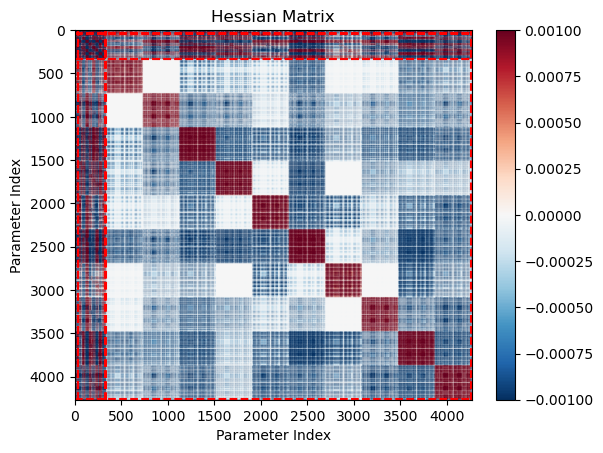

In [63]:
%matplotlib inline
plot_hessian(model, criterion, x_samples, y_samples)
plt.show()

c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Project Course - Sem 4\DeepHessian\PyHessian\density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


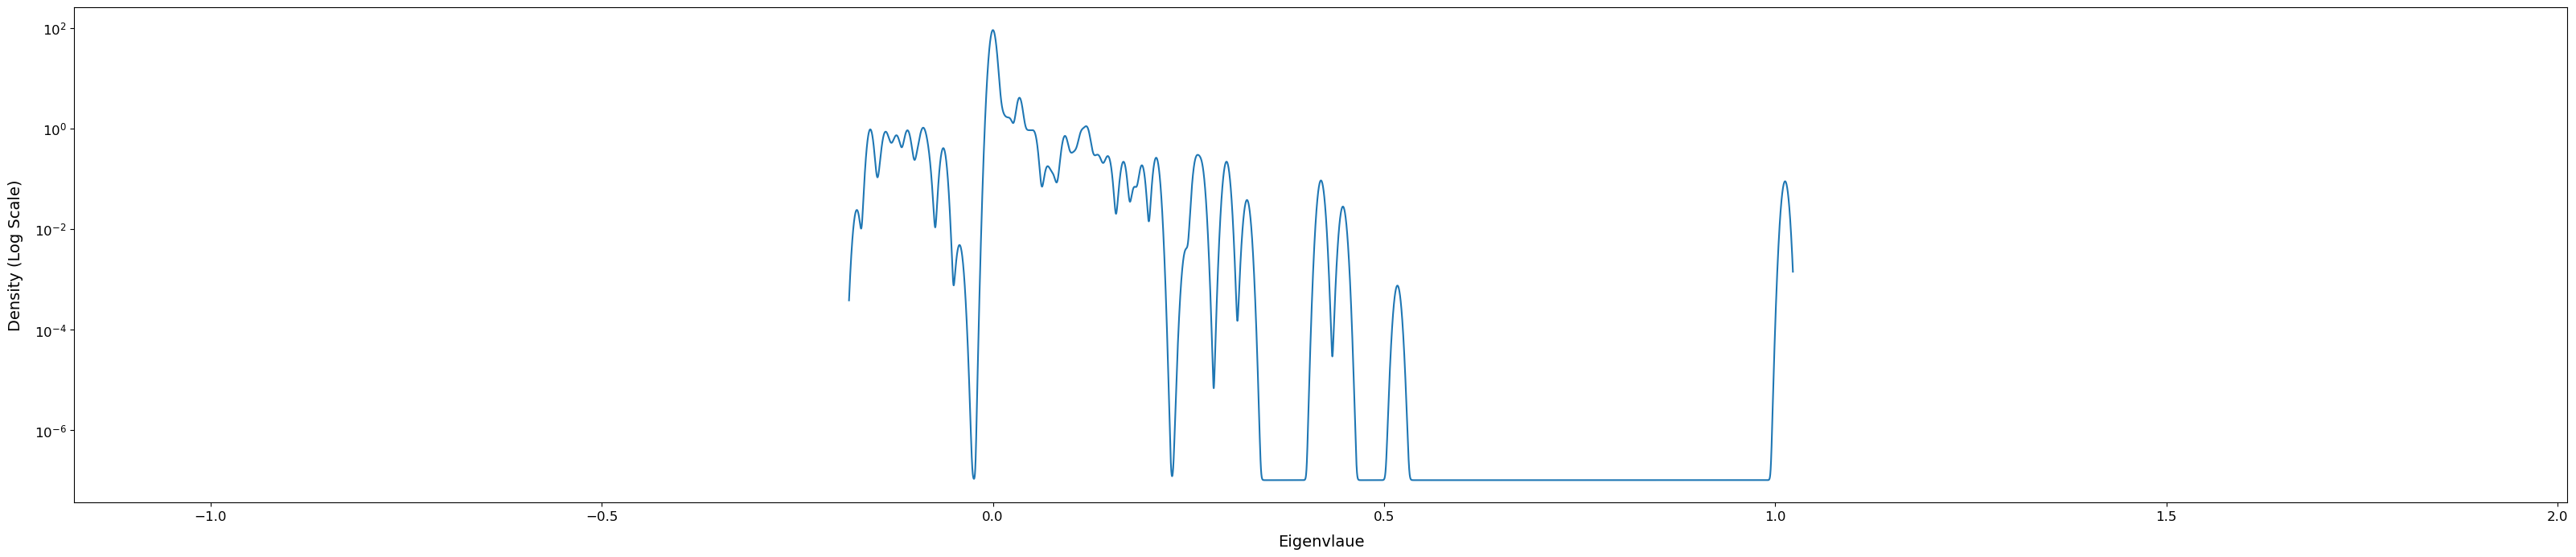

In [8]:
get_esd_plot(*predicted_hessian.density())

In [18]:
true_couple = list(zip(true_vals, true_vecs))
# Sort the couple based on absolute value of the eigenvalues
true_couple.sort(key=lambda x: abs(x[0]))
true_couple.reverse()

In [21]:
# Reconstructing the Hessian matrix using the eigenvectors and eigenvalues and finding the error
reconstructed_hessians = []
current_hessian = torch.zeros(true_hessian.shape)
for i in range(len(true_couple)):
    val, vec = true_couple[i]
    vec = torch.tensor(vec, dtype=torch.float32)
    reconstructed_hessian = val * torch.outer(vec, vec)
    current_hessian += reconstructed_hessian
    error = torch.norm(current_hessian - true_hessian) / torch.norm(true_hessian)
    reconstructed_hessians.append((current_hessian, error))

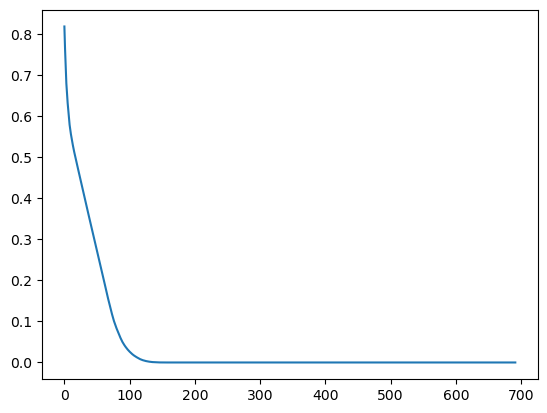

In [22]:
# Plotting the error in reconstructing the Hessian matrix
plt.plot([err for _, err in reconstructed_hessians])

In [53]:
def get_reconstruction_loss(matrix):
    vals, vecs = np.linalg.eigh(matrix)
    vecs = vecs.T
    couple = list(zip(vals, vecs))
    couple.sort(key=lambda x: abs(x[0]))
    couple.reverse()
    current_matrix = np.zeros(matrix.shape)
    errors = []
    for i in range(len(couple)):
        val, vec = couple[i]
        reconstructed_matrix = val * np.outer(vec, vec)
        current_matrix += reconstructed_matrix
        error = np.linalg.norm(current_matrix - matrix) / np.linalg.norm(matrix)
        errors.append(error)
    return errors

def plot_reconstruction_loss(errors, epsilon=None, title="Reconstruction Loss", save_path = None):
    plt.plot(errors)
    plt.xlabel("Number of Eigenvalues")
    plt.ylabel("Relative Error")
    plt.title(title)
    if epsilon is not None:
        num_required = np.argmax(np.array(errors) < epsilon)
        plt.axvline(x=num_required, color='r', linestyle='--', label=f"Number of Eigenvalues: {num_required} for epsilon={epsilon}")
        plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

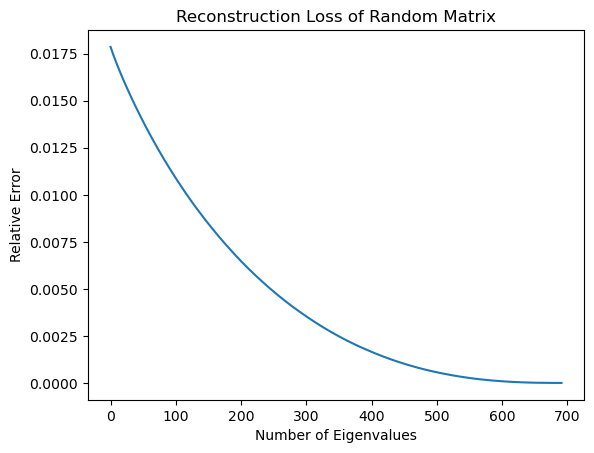

In [48]:
# Using a random matrix to test the function
random_matrix = np.random.rand(692, 692)
random_matrix = random_matrix @ random_matrix.T
errors = get_reconstruction_loss(random_matrix)
plot_reconstruction_loss(errors, title="Reconstruction Loss of Random Matrix")

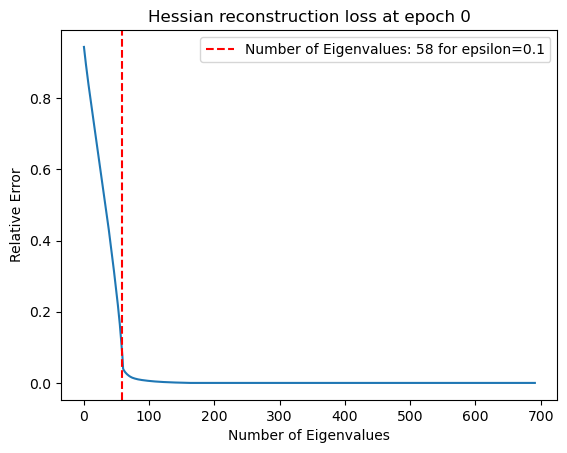

Epoch 1/10, Loss: 0.4335149824619293


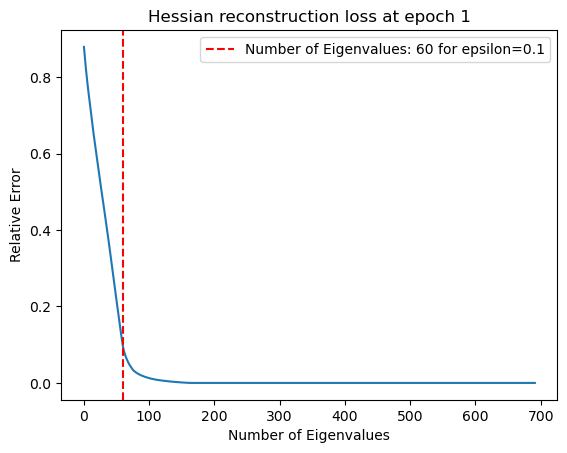

Epoch 2/10, Loss: 0.29747194051742554


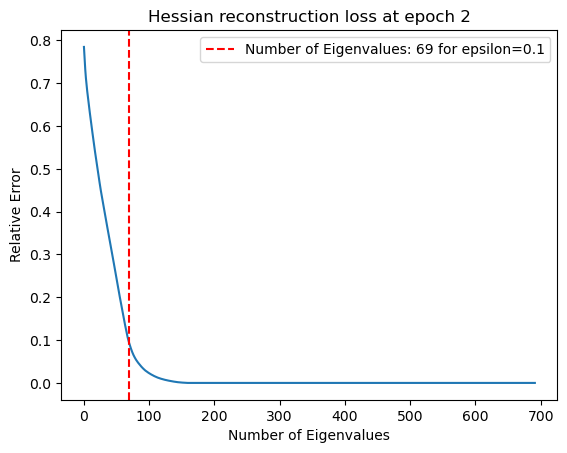

Epoch 3/10, Loss: 0.30184406042099


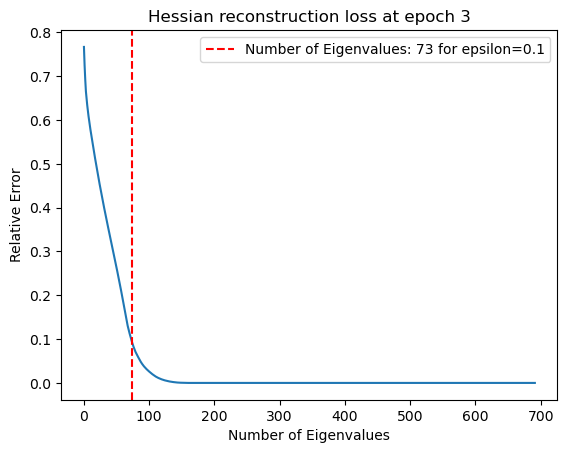

Epoch 4/10, Loss: 0.24865324795246124


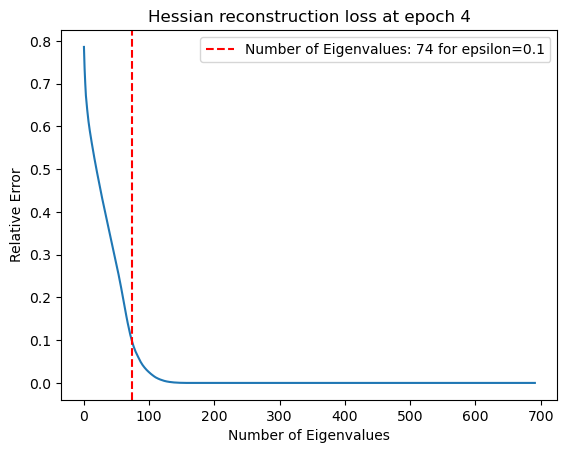

Epoch 5/10, Loss: 0.27769243717193604


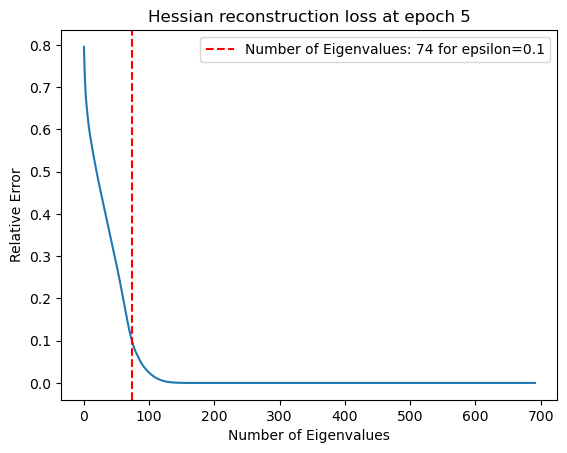

Epoch 6/10, Loss: 0.3662484586238861


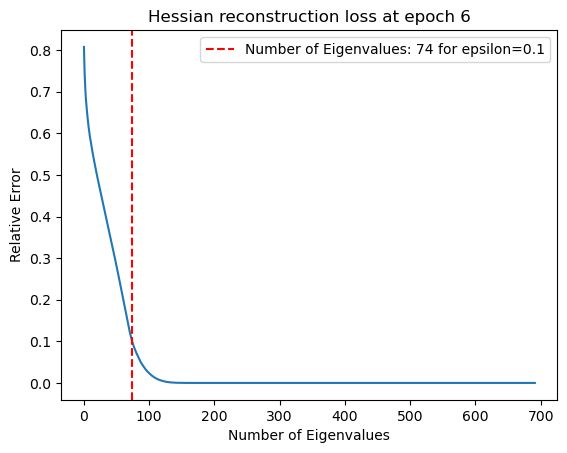

Epoch 7/10, Loss: 0.1788696050643921


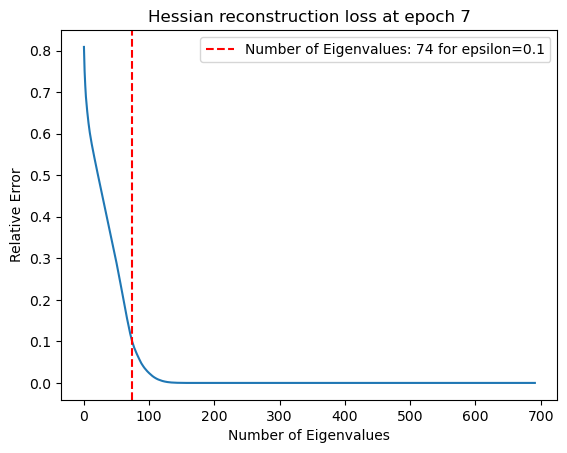

Epoch 8/10, Loss: 0.32214534282684326


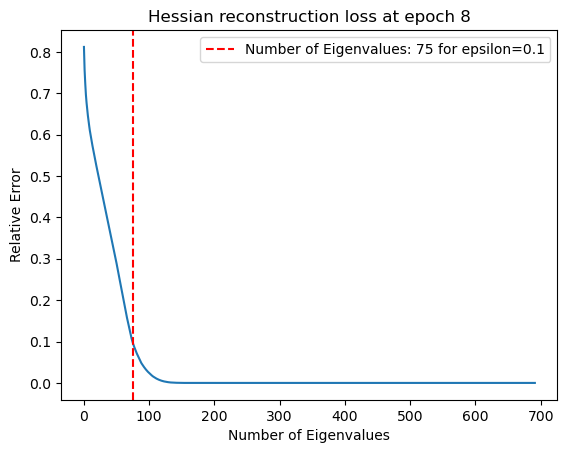

Epoch 9/10, Loss: 0.1033029556274414


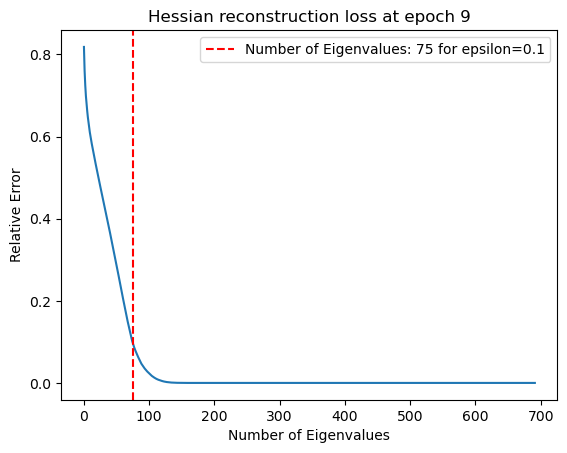

Epoch 10/10, Loss: 0.18579581379890442


In [56]:
# Finding hessian matrix per epoch and plotting the error in reconstruction
model = SmallModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epsilon = 1e-1
num_req_arr = []
num_epochs = 10
for epoch in range(num_epochs):
    hessian_matrix = np.array(compute_hessian(model, criterion, x_samples, y_samples))
    errors = get_reconstruction_loss(hessian_matrix)
    num_required = np.argmax(np.array(errors) < epsilon)
    num_req_arr.append(num_required)
    plot_reconstruction_loss(errors, epsilon=epsilon, title=f"Hessian reconstruction loss at epoch {epoch}", save_path= f"hessian_reconstruction/epoch_{epoch}.png")
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

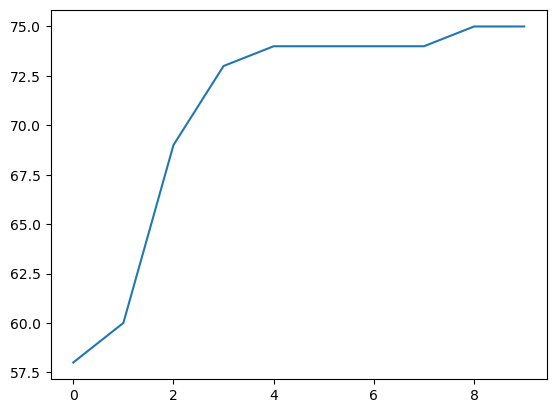

In [57]:
plt.plot(num_req_arr)